# **<center> <span style="color: pink;">ATML PA_0 </span>**

### <span style="color: DeepPink;"> Name : Khadeeja Toseef </span>
### <span style="color: DeepPink;"> Roll Number : 27100309 </span>

## <center> <span style="color: pink;">Task 2: Understanding Vision Transformers (ViT) </span>

### <span style="color: HotPink;"> 1. Using a Pre-trained ViT for Image Classification: </span>

<span style="color: #D8BFD8;">importing libraries </span>


In [39]:
import torch
import numpy as np
from math import sqrt
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor

### <span style="color: HotPink;"> 2. Visualizing Patch Attention:</span>

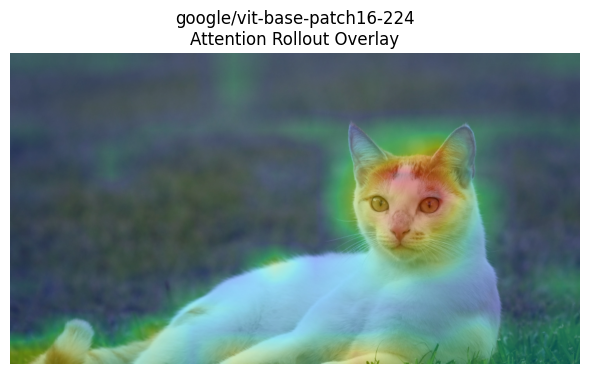

Top-1 prediction: Egyptian cat (class id 285)


In [40]:

MODEL_NAME = "google/vit-base-patch16-224"
IMAGE_PATH = "/Users/khadeeja/Desktop/lums/junior/semester 5/atml/assignments/pa0/task2data/cat.png"    
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# attention implementation = eager to return attentions 
model = ViTForImageClassification.from_pretrained(MODEL_NAME, attn_implementation="eager").to(DEVICE)
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model.eval()

img = Image.open(IMAGE_PATH).convert("RGB")
inputs = processor(images=img, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions  # tuple of length L=12, each [1, heads, tokens, tokens]

# attention rollout: implements Abnar & Zuidema (2020) cumulative attention.
tokens = attentions[0].size(-1) # num tokens = num_patches + 1 (CLS)
rollout = torch.eye(tokens).to(DEVICE)

for layer_attn in attentions:
    # (a) average over heads → [tokens, tokens]
    attn_heads_fused = layer_attn[0].mean(dim=0)
    # (b) add identity matrix to account for self-residuals
    attn_heads_fused = attn_heads_fused + torch.eye(tokens).to(DEVICE)
    # (c) normalize rows
    attn_heads_fused = attn_heads_fused / attn_heads_fused.sum(dim=-1, keepdim=True)
    # (d) accumulate
    rollout = attn_heads_fused @ rollout

# extract CLS -> PATCH vector
# rollout[0] is attention *to* CLS; rollout[0,1:] are weights from CLS→each patch
cls_attn = rollout[0, 1:] # shape: (num_patches,)

# reshape to grid
num_patches = cls_attn.shape[0] # e.g. 196 for 14×14
side = int(sqrt(num_patches))        
attn_map = cls_attn.reshape(side, side).cpu().numpy()
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min()) # normalize 0–1
mask = Image.fromarray(np.uint8(attn_map * 255)) # convert back to PIL
mask = mask.resize(img.size, resample=Image.BICUBIC)
mask = mask.filter(ImageFilter.GaussianBlur(radius=2))

# make RGBA overlay (red heatmap)
mask_array = np.array(mask)
heat = np.zeros((*mask_array.shape, 4), dtype=np.uint8)
heat[..., 0] = 255  # red channel
heat[..., 3] = mask_array  # alpha = intensity
overlay = Image.fromarray(heat, mode="RGBA")
attn_map_resized = np.array(
    Image.fromarray(attn_map).resize(img.size, resample=Image.BILINEAR)
)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(img)
ax.imshow(attn_map_resized, cmap='jet', alpha=0.3)
ax.axis("off")
plt.title(f"{MODEL_NAME}\nAttention Rollout Overlay")
plt.tight_layout()
plt.show()

# --- after outputs = model(**inputs, output_attentions=True) ---
logits = outputs.logits               # shape [1, num_classes]
pred_id = logits.argmax(dim=-1).item()  # get the top class index
pred_label = model.config.id2label[pred_id]  # map to human label
print(f"Top-1 prediction: {pred_label} (class id {pred_id})")



### <span style="color: HotPink;"> 3. Analyze the Attention Map: </span>

### <span style="color: HotPink;"> 4. Mask a fraction of input patches at inference and observe the effect on accuracy. How robust is ViT to missing patches? Why? Compare random masking with structured masking (e.g., masking the center). What do you observe?
</span>

In [ ]:
def mask_input_patches(inputs, mode='random', fraction=0.3):
    """
    Mask a fraction of patch tokens (not CLS) in the input embeddings.
    mode: 'random' or 'center'
    fraction: how many patches to mask
    """
    # Get input embeddings
    with torch.no_grad():
        embeddings = model.vit.embeddings(inputs['pixel_values'])  # [1, num_tokens, hidden_size]
    
    cls_token = embeddings[:, 0:1, :]     # shape [1, 1, hidden_dim]
    patch_tokens = embeddings[:, 1:, :]   # shape [1, num_patches, hidden_dim]
    num_patches = patch_tokens.shape[1]
    
    mask = torch.ones(num_patches, dtype=torch.bool)

    if mode == 'random':
        idx = torch.randperm(num_patches)[:int(fraction * num_patches)]
        mask[idx] = False
    elif mode == 'center':
        side = int(sqrt(num_patches))
        center = side // 2
        size = int(sqrt(fraction) * side)
        half = size // 2
        for i in range(center - half, center + half):
            for j in range(center - half, center + half):
                mask[i * side + j] = False
    
    patch_tokens[:, ~mask, :] = 0  # mask out selected tokens
    
    new_embeddings = torch.cat([cls_token, patch_tokens], dim=1)
    return new_embeddings

def run_model_with_masked_input(embeddings):
    """
    Pass manually patched embeddings through transformer encoder and classifier.
    """
    with torch.no_grad():
        encoder_outputs = model.vit.encoder(embeddings)
        cls_output = encoder_outputs.last_hidden_state[:, 0]  # take CLS token
        logits = model.classifier(cls_output)
        pred_id = logits.argmax(dim=-1).item()
        pred_label = model.config.id2label[pred_id]
    return pred_label, pred_id


In [48]:
masked_emb_random = mask_input_patches(inputs, mode='random', fraction=0.3)
masked_emb_center = mask_input_patches(inputs, mode='center', fraction=0.3)

label_random, _ = run_model_with_masked_input(masked_emb_random)
label_center, _ = run_model_with_masked_input(masked_emb_center)

print(f"Original Prediction: {pred_label}")
print(f"Random Masked Prediction: {label_random}")
print(f"Center Masked Prediction: {label_center}")


Original Prediction: Egyptian cat
Random Masked Prediction: Egyptian cat
Center Masked Prediction: Egyptian cat


### <span style="color:DarkCyan;"> How robust is ViT to missing patches? Why? Compare random masking with structured masking (e.g., masking the center). What do you observe?
</span>

ANSWER = <span style="color: #D8BFD8;">
... 
</span>

### <span style="color: HotPink;"> 5. Compare linear probes trained on the CLS token versus the mean of patch tokens.
</span>

In [44]:
def get_embeddings(inputs):
    with torch.no_grad():
        embeddings = model.vit.embeddings(inputs['pixel_values'])  # [1, tokens, dim]
        encoder_outputs = model.vit.encoder(embeddings)
    return encoder_outputs.last_hidden_state  # [1, tokens, dim]

def classify_with_pooling(hidden_states, method='cls'):
    """
    Pooling method: 'cls' or 'mean'
    """
    if method == 'cls':
        pooled = hidden_states[:, 0]  # CLS token
    elif method == 'mean':
        pooled = hidden_states[:, 1:].mean(dim=1)  # average over patch tokens
    else:
        raise ValueError("Unsupported pooling method")
    
    with torch.no_grad():
        logits = model.classifier(pooled)
        pred_id = logits.argmax(dim=-1).item()
        pred_label = model.config.id2label[pred_id]
    return pred_label, pred_id


In [45]:
hidden = get_embeddings(inputs)
label_cls, _ = classify_with_pooling(hidden, method='cls')
label_mean, _ = classify_with_pooling(hidden, method='mean')

print(f"CLS Token Prediction: {label_cls}")
print(f"Mean Pooling Prediction: {label_mean}")


CLS Token Prediction: Egyptian cat
Mean Pooling Prediction: Egyptian cat


### <span style="color:DarkCyan;"> Which pooling method performs better? Why? How might this choice interact with different pretraining objectives?
</span>

ANSWER = <span style="color: #D8BFD8;">
... 
</span>